In [35]:
from transformers import AutoProcessor, AutoModelForTokenClassification
import torch
import os
from pathlib import Path
ROOT_DIR = Path(os.getcwd()).parent
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [36]:
from datasets import load_dataset 

# this dataset uses the new Image feature :)
dataset = load_dataset("./dataset_loader.py")

In [67]:

labels = ['page_number', 'building_material', 'settlement_classification', 'parish', 'building_type', 'dedication', 'deanery']
bio_labels = ["B-{}".format(label) for label in labels] + ["I-{}".format(label) for label in labels] + ["O"]

label2id = {label: i for i, label in enumerate(bio_labels)}
id2label = {i: label for i, label in enumerate(bio_labels)}


num_labels = len(id2label)

model = AutoModelForTokenClassification.from_pretrained(os.path.join(ROOT_DIR, "layoutLMv3/test_focal/checkpoint-400"), num_labels=num_labels, id2label=id2label, label2id=label2id)

processor = AutoProcessor.from_pretrained(
    "microsoft/layoutlmv3-large",
    apply_ocr=True
)

In [73]:
from PIL import Image

image = Image.open("/Users/user/Projects/ecclesiasticalOCR/layoutLMv3/images/0016.jpg").convert("RGB")      # twoja funkcja / pytesseract

inputs = processor(image, return_tensors="pt", truncation=True, max_length=512)
with torch.no_grad():
    logits = model(**inputs).logits

pred_ids   = logits.argmax(-1).squeeze().tolist()
pred_labels= [model.config.id2label[i] for i in pred_ids]
print(set(pred_labels))

/opt/anaconda3/envs/ocr/lib/python3.12/site-packages/transformers/modeling_utils.py:1558: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


{'I-parish', 'B-dedication', 'I-dedication', 'B-settlement_classification', 'B-building_material', 'B-parish', 'B-page_number', 'B-building_type', 'O'}


In [61]:
def unnormalize_box(bbox, width, height):
     return [
         width * (bbox[0] / 1000),
         height * (bbox[1] / 1000),
         width * (bbox[2] / 1000),
         height * (bbox[3] / 1000),
     ]


In [89]:
import numpy as np
import random

def sliding_window(token_boxes, predictions, encoding, width, height):
    # ---------------------------------------------------------------------
    # 1. bbox -> tekst (scalanie tokenów)
    # ---------------------------------------------------------------------
    box_token_dict = {}

    for i in range(len(token_boxes)):
        initial_j = 0 if i == 0 else 129          # stride = 128

        for j in range(initial_j, len(token_boxes[i])):

            # ====== FILTRY krytyczne ======
            if predictions[i][j] == 0:                 # pomin 'O'
                continue
            if np.asarray(token_boxes[i][j]).shape != (4,):
                continue
            if token_boxes[i][j] == [0, 0, 0, 0]:
                continue
            # ==============================

            unnormal_box = unnormalize_box(token_boxes[i][j], width, height)
            bbox = tuple(unnormal_box)

            # nie nadpisuj, jeśli bbox już dodany (duplikat z innego okna)
            if bbox in box_token_dict:
                continue

            token = processor.tokenizer.decode(encoding["input_ids"][i][j])
            box_token_dict[bbox] = [token]

    box_token_dict = {bbox: [''.join(words)]
                      for bbox, words in box_token_dict.items()}

    boxes = list(box_token_dict.keys())
    words = list(box_token_dict.values())

    # ---------------------------------------------------------------------
    # 2. bbox -> lista predykcji (głosowanie okien)
    # ---------------------------------------------------------------------
    box_prediction_dict = {}

    for i in range(len(token_boxes)):
        for j in range(len(token_boxes[i])):

            # ====== te same filtry ======
            if predictions[i][j] == 0:
                continue
            if np.asarray(token_boxes[i][j]).shape != (4,):
                continue
            if token_boxes[i][j] == [0, 0, 0, 0]:
                continue
            # ============================

            bbox = tuple(token_boxes[i][j])
            pred = predictions[i][j]
            box_prediction_dict.setdefault(bbox, []).append(pred)

    # ---------------------------------------------------------------------
    # 3. majority vote + heurystyka sąsiedztwa
    # ---------------------------------------------------------------------
    preds = []
    for idx, (bbox, pred_list) in enumerate(box_prediction_dict.items()):

        counts = {p: pred_list.count(p) for p in set(pred_list)}
        max_cnt = max(counts.values())
        max_preds = [p for p, c in counts.items() if c == max_cnt]

        if len(max_preds) == 1:
            preds.append(max_preds[0])
            continue

        # ---- rozstrzyganie remisu (wersja z 'others' zostaje) ----
        others_id = next((id_ for id_, lab in id2label.items()
                          if lab == 'others'), None)

        if others_id in max_preds and len(max_preds) > 1:
            tmp_counts = counts.copy()
            tmp_counts.pop(others_id)
            if tmp_counts:
                new_max = max(tmp_counts.values())
                new_max_preds = [p for p, c in tmp_counts.items()
                                 if c == new_max]
                if len(new_max_preds) == 1:
                    preds.append(new_max_preds[0])
                    continue
                max_preds = new_max_preds  # bez 'others'

        # ---- heurystyka: zgodność z sąsiadami ----
        neighbor_preds = []
        if idx - 1 >= 0:
            neighbor_preds += box_prediction_dict[
                list(box_prediction_dict.keys())[idx - 1]]
        if idx + 1 < len(box_prediction_dict):
            neighbor_preds += box_prediction_dict[
                list(box_prediction_dict.keys())[idx + 1]]

        common = list(set(max_preds) & set(neighbor_preds))
        if common:
            preds.append(random.choice(common))
        else:
            preds.append(random.choice(max_preds))

    flattened_words = [w[0].strip() for w in words]

    return boxes, preds, flattened_words


In [87]:
def visualize_entity_boxes(image_path, boxes, preds, words, id2label, output_path=None):
    """
    Visualize detected entities on an image.
    
    Args:
        image_path (str): Path to the image file
        boxes (list): List of bounding boxes as tuples/lists (x1, y1, x2, y2)
        preds (list): List of prediction IDs (integers)
        words (list): List of word text for each box
        id2label (dict): Dictionary mapping prediction IDs to label strings
        output_path (str, optional): If provided, save visualization to this path
    
    Returns:
        PIL.Image: Annotated image
    """
    from PIL import Image, ImageDraw, ImageFont
    import os
    
    # Load image
    image = Image.open(image_path).convert("RGB")
    image_draw = image.copy()
    draw = ImageDraw.Draw(image_draw)
    
    # Try to load a nicer font, fall back to default if not available
    try:
        font = ImageFont.truetype("Arial", 12)
    except IOError:
        font = ImageFont.load_default()
    
    # Color mapping for different entity types
    label2color = {
        'building_material': 'red',
        'building_type': 'blue',
        'deanery': 'green',
        'dedication': 'orange',
        'page_number': 'purple',
        'parish': 'brown',
        'settlement_classification': 'cyan',
        'O': 'gray'  # "Outside" entity
    }
    
    # Draw each entity with its label
    for i, (box, pred, word) in enumerate(zip(boxes, preds, words)):
        # Get label from prediction ID
        label = id2label.get(pred, "O")
        
        # Skip "O" (Outside) labels to focus only on named entities
        if label == "O":
            continue
            
        print(f"Drawing box for word: {word}, label: {label}, box: {box}")
        # Extract entity type from BIO tag (e.g., "B-parish" -> "parish")
        if label.startswith("B-") or label.startswith("I-"):
            entity_type = label[2:]
        else:
            entity_type = label
            
        # Get color for this entity type
        color = label2color.get(entity_type, 'yellow')  # Default to yellow if unknown
        
        # Draw bounding box
        draw.rectangle(box, outline=color, width=2)
        
        # Create label text with entity type and word
        label_text = f"{entity_type}: {word}"
        
        # Calculate text position (above the box)
        text_y = max(0, box[1] - 15)
        
        # Add background for text
        text_width = draw.textlength(label_text, font=font)
        # draw.rectangle(
        #     [box[0], text_y, box[0] + text_width, text_y + 15],
        #     fill=(255, 255, 255, 180)  # Semi-transparent white background
        # )
        draw.rectangle(box, outline=color, width=3)

        
        # Draw text
        draw.text(
            (box[0], text_y),
            label_text,
            fill=color,
            font=font
        )
    
    # Save if output path provided
    if output_path:
        image_draw.save(output_path)
    
    return image_draw

/var/folders/lw/767gd31d7d3ctzj1jms858l80000gn/T/ipykernel_30091/606097070.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  encoding[k] = torch.tensor(v)
/opt/anaconda3/envs/ocr/lib/python3.12/site-packages/transformers/modeling_utils.py:1558: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


torch.Size([2, 512, 15])
Drawing box for word: 9, label: B-parish, box: (97.75, 364.8, 124.2, 391.4)
Drawing box for word: D, label: I-parish, box: (147.20000000000002, 362.90000000000003, 269.1, 402.8)
Drawing box for word: p, label: B-settlement_classification, box: (300.15000000000003, 374.3, 328.9, 400.9)
Drawing box for word: TE, label: B-building_type, box: (351.9, 364.8, 412.84999999999997, 393.29999999999995)
Drawing box for word: SS, label: I-dedication, box: (432.4, 364.8, 486.45, 393.29999999999995)
Drawing box for word: Simon, label: I-dedication, box: (518.65, 364.8, 625.6, 393.29999999999995)
Drawing box for word: et, label: I-dedication, box: (649.7499999999999, 368.6, 672.75, 391.4)
Drawing box for word: Jud, label: I-dedication, box: (696.9, 364.8, 765.9000000000001, 393.29999999999995)
Drawing box for word: Ap, label: I-dedication, box: (801.55, 364.8, 856.75, 400.9)
Drawing box for word: 10, label: B-parish, box: (98.89999999999999, 801.8, 141.45, 830.3)
Drawing box 

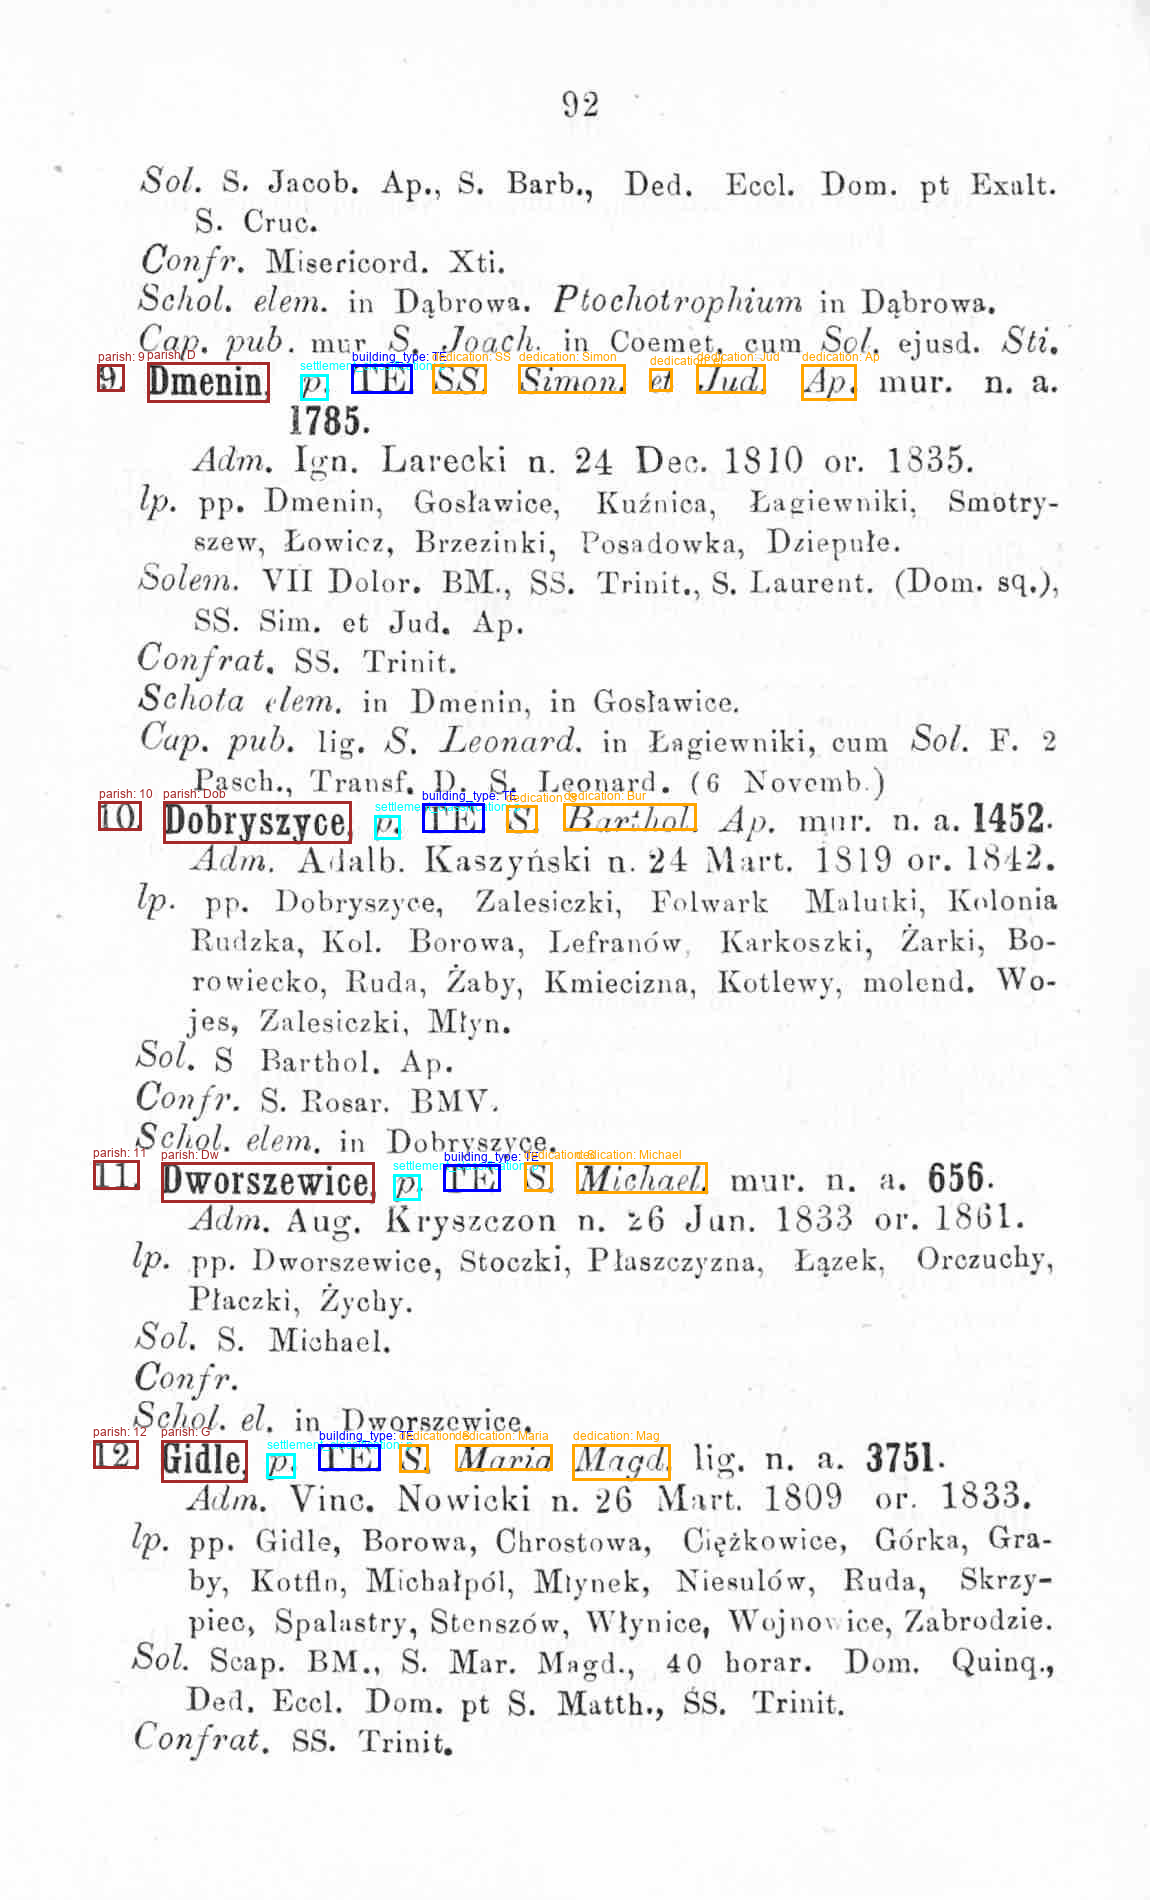

In [95]:
# change the shape of pixel values
import random

for example in dataset["test"]:

    word_labels = example["ner_tags"]
    image = example["image"]
    image_width, image_height = example["image"].size
    encoding = processor(image, truncation=True, stride =128, 
            padding="max_length", max_length=512, return_overflowing_tokens=True, return_offsets_mapping=True)

    offset_mapping = encoding.pop('offset_mapping')

    overflow_to_sample_mapping = encoding.pop('overflow_to_sample_mapping')

    x = []
    for i in range(0, len(encoding['pixel_values'])):
        ndarray_pixel_values = encoding['pixel_values'][i]
        # Convert to tensor
        tensor_pixel_values = torch.tensor(ndarray_pixel_values)
        # Reshape to (3, 224, 224)
        #tensor_pixel_values = tensor_pixel_values.reshape(3, 224, 224)
        x.append(tensor_pixel_values)
        # Reshape to (3, 224, 224)

    x = torch.stack(x)

    encoding['pixel_values'] = x

    for k, v in encoding.items():
        encoding[k] = torch.tensor(v)

    with torch.no_grad():
        outputs = model(**encoding)

    # The model outputs logits of shape (batch_size, seq_len, num_labels).
    logits = outputs.logits
    print(logits.shape)

    # We take the highest score for each token, using argmax. This serves as the predicted label for each token.
    predictions = logits.argmax(-1).squeeze().tolist()
    token_boxes = encoding.bbox.squeeze().tolist()

    if (len(token_boxes) == 512):
        predictions = [predictions]
        token_boxes = [token_boxes]

    boxes, preds, flattened_words = sliding_window(token_boxes, predictions, encoding, image_width, image_height)

    result_image = visualize_entity_boxes(
        example["image_path"],
        boxes,
        preds,
        flattened_words,
        id2label,
        output_path="visualization_output.jpg"  # Optional
    )

    # Display in notebook
    from IPython.display import display
    display(result_image)
    break